

<p><img height="80px" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/UPM/Escudo/EscUpm.jpg" align="left" hspace="0px" vspace="0px"></p>

**Course "Artificial Neural Networks and Deep Learning" - Universidad Politécnica de Madrid (UPM)**

# **Deep Q-Learning for Lunar lander**

This notebook includes an implementation of the Deep Q-learning (DQN) algorithm for the lunar lander problem (see [OpenAI's LunarLander-v2](https://gym.openai.com/envs/LunarLander-v2/)).


# Organización del directorio

Es importante tener en cuenta que hemos decidido guardar dos agentes. El primero es el resultado de llevar a cabo la ejecución completa y el segundo es el agente con el avg_score más alto que se ha obtenido. Es por ello que aunque el primero puede que haya acabado con malos resultados, el segundo seguirá siendo el mejor agente obtenido en el entrenamiento.

La entrega realizada viene en un solo directorio que contiene de primeras los siguientes archivos:

*   **agente:** es el objeto de la clase DQN que contiene el agente entrenado.
*   **agente.h5:** es el modelo de keras que contiene el objeto de la clase DQN.
*   **model_conf.xlsx:** es la configuración de los hiperparámetros del agente.
*   **resultados.xlsx:** son los resultados de cada episodio en la fase de entrenamiento.

También se pueden encontrar los siguientes directorios:

*   **videos:** contiene los vídeos obtenidos a lo largo del entrenamieto. Estos vídeos se han grabado cada 20 episodios.
*   **best_score:** contiene el agente y el agente.h5 con los mejores resultados obtenidos en el entrenamiento.


# Organización del cuaderno

El cuaderno se divide en las siguientes secciones:
- Sección 0: Una introducción acerca del entorno y del problema a resolver. Además, aquí se configura la ruta al directorio de trabajo.
- Sección 1: Contiene todas las funciones necesarias para que se puede ejecutar un modelo en el entorno "Lunar Lander". En ella se definen las clases *DQN* y *Memory*, además de diversas funciones para que se pueda mostrar un vídeo de la ejecución.
- Sección 2: Contiene las funciones para entrenar un modelo en el entorno "Lunar Lander" y guardarlo junto con los vídeos de las ejecuciones.
- Sección 3: Permite importar un modelo ya entrenado y ejecutarlo en el entorno "Lunar Lander". Como resultado mostrará el score obtenido y la cantidad de transiciones que hay almacenadas en la memoria y un vídeo de la ejecución.

Este cuardeno ya está configurado para cargar el mejor modelo contenido en el directorio donde se encuentra este mismo cuaderno. Lo único que hay que añadir es la ruta de su google drive hasta donde se encuentra este directorio.

# 0. Introducción

## 0.1. Cómo utilizar el cuaderno

En primer lugar se debe ejecutar la sección 1. Dentro de está se encuentra el apartado 1.1, que se encarga de instalar todas las dependencias necesarias, por lo que probablemente sea necesario reiniciar el cuaderno después de la primera ejecución.

La ejecución de la sección 2 permite entrenar un nuevo agente. 

Si se desea importar y ejectuar un modelo ya existente, debe ejecutarse la sección 3.

## 0.2. Entorno Lunar lander

Lunar lander simulator from [Open Ai Gym](https://gym.openai.com/envs/LunarLander-v2/):

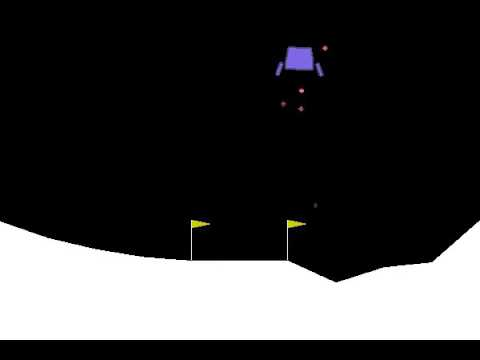

**Código de lunar_lander.py:**
https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py#L258


**State vector**(observaciones):
- state[0]: Coordenada en el eje X
- state[1]: Coordenada en el eje Y
- state[2]: Velocidad horizontal
- state[3]: Velocidad vertical
- state[4]: Ángulo
- state[5]: Velocidad angular
- state[6]: Contacto de la pierna izquierda
- state[7]: Contacto de la pierna derecha

**Actions**:
- 0 No hacer nada
- 1 Encender el motor principal (empujar hacia arriba)
- 2 Encender el motor izquierdo motor izquierdo (empujar a la derecha)
- 3 Encender el motor derecho (empujar a la izquierda)

**Información adicional**:
- **Inicio**: El vehículo parte de la parte superior de la pantalla (con velocidad inicial aleatoria) y la plataforma de aterrizaje está siempre en las coordenadas (0,0).
- **Recompensa**: 

    -**Según el estado actual**
      shaping = (
                -100 * sqrt(x^2 + y^2)       # Distancia al centro (0,0)
                -100 * sqrt(Vy^2 + Vx^2)     # Distancia a velocidad (0,0)
                -100 * abs(ángulo)
                +10 * contacto pierna izq
                +10 * contacto pierna drch
                )
        
        # Esta resta se hace para no acumular las recompensas y que en cada
        # iteración tengamos únicamente el de la propia operación.
        reward = shaping - prev_shaping
    -**Según el combustible usado**
      reward -= m_power * 0.3    # Main engine
      reward -= s_power - 0.03   # Side engine

    -**Según el estado final de la nave**
      if game_over o se sale del mapa (creo):
        reward = -100
      if aterriza
        reward = +100

##0.3. Modificaciones al modelo

### 1. Relativas a la estructura de DQN

  En este apartado se van a explicar los cambios realizados en la clase DQN.

####  1.1 Target Network

  El uso de una target network en DQN proporciona estabilidad en el entrenamiento. Esta red tiene la misma estructura que la utilizada para el aprendizaje, con la diferencia de que los pesos de esta no se actualizan en cada paso, si no que se realiza cada k número de iteraciones. 

  El objetivo de esta práctica es utilizar valores objetivo más estables, es decir, que no varíen tanto debido al aprendizaje de la propia red, que los actualiza en cada iteración.

####  1.2 Discretización de los estados

  Esta modificación es relativa al entorno que estamos tratando y a la manera en que el agente intereactúa con él. La información que recibe el agente del entorno son valores reales relativos a la posición, velocidad e inclinación, y estos números tiene una precisión con bastantes decimales. El problema surge cuando se generan una gran cantidad de diferentes estados, lo que aumenta en gran medida la dificultad para el aprendizaje de la red.

Una solución a este problema pasa por discretizar esos valores y acotarlos en un determinado rango. Nosotros hemos decidido discretizar estos números en intervalos de 0.5. 

Por otro lado, hemos acotado el rango en el que están definidas estas mediciones del entorno. Por ejemplo, en el caso de la posición, se ha determinado una cierta región fuera de la cual ya no es relevante si la cápsula se encuentra más lejos o más cerca, devolviendo un valor fijo y consiguiendo así que el agente únicamente esté manejando un estado para cualquier posición en ese rango, teniendo que procesar menos información.

A continuación se incluye el rango posible originalmente para cada una de las variables de un estado y el rango en el que se han acotado. 

    - Posición x:
      
      Inicial = [-1, 1]     
      Acotado = [-0.5, 0.5]
    
    - Posición y:
    
      Inicial = [-2, 10]  
      Acotado = [5, -1]
    
    - Velocidad x:
      
      Inicial = [-4, 4]  
      Acotado = [-1, 1]

    - Velocidad y:

      Inicial = [-4, 4]  
      Acotado = [-1, 1]
    
    - Ángulo:

      Inicial = [-3, 3]  
      Acotado = [-1, 1]

    - Velocidad angular:

      Inicial = [-3, 3]  
      Acotado = [-1, 1]


### 2. Relativas a los hiperparámetros:
- **Batch**: Es el número de ejemplos que procesará el modelo antes de actualizar los pesos de la red neuronal. Se han probado configuraciones de 256, 128, 64 y 32, obteniéndose los mejores resultados para un tamaño de batch de 64. Por temas de estructura de computadores es recomendable emplear tamaños de batch de potencias de dos y por eso no se han probado valores fuera de esta restricción.
- **Exploration Decay**: Los modelos de aprendizaje por refuerzo se basan en un balance entre exploración, es decir, la selección una acción de forma aleatoria para conocer mejor el entorno, y explotación, que consiste en seleccionar una acción que trate de maximizar la recompensa. Se han probado configuraciones comprendidas entre el rango 0.99 y 1, e incluso se probó a planificar por episodio,reduciendo a la mitad la tasa de exploración cada 50 época comenzando por 0.5. Sin embargo, los mejores resultados se han conseguido con un Exploration Decay de 0.9998.
- **Gamma**: Es el factor de descuento. Cuantifica la importancia que damos a las recompensas futuras. Gamma varía de 0 a 1. Si Gamma está más cerca de cero, el agente tenderá a considerar sólo las recompensas inmediatas. Si Gamma está más cerca de uno, el agente considerará las recompensas futuras con mayor peso, dispuesto a retrasar la recompensa. En nuestro caso, dado que el objetivo final es aterrizar la nave de forma adecuada, hemos decidido mantenerlo en 0.99, siendo las recompensas intermedias menos relevantes.
- **Neurons**: Es el número de nodos por capa que tendrá nuestra red o modelo. La capa de entrada viene determinada por 8 nodos, cada uno de ellos representa una variable perteneciente al estado en el que se encuentra la nave a aterrizar. Por su parte, la capa de salida corresponde a cada una de las 4 acciones que pueden ejecutarse en el entorno, por lo que serán 4 neuronas. En cuanto a las capas intermedias, se han probado multitud de configuraciones como : [256, 128, 64], [128, 128], [128, 64, 32], [64, 32], sin embargo la que mejores resultados ha logrado ha sido [128, 64, 32].
- **Update_w**: Establece cada cuantos pasos se van a copiar los pesos del modelo que esta aprendiendo sobre el modelo target. Nuevamente se han probado múltiples configuraciones, alcanzándose los mejores resultados con un valor de 100. 
- **Learning rate (lr)**: Determina en qué grado varían los pesos de las neuronas durante la fase de retropropagación del gradiente. En general hemos observado que un lr relativamente pequeños se adaptan mejor a este problema, tras numerosas pruebas, se ha determinado como bueno para el lr el intervalo comprendido entre 0.001 y 0.003.
- **Intermediate activations**: Determina la función de activación utilizada en las capas intermedias de la red. Se ha comprobado que ReLu ha logrado los mejores resultados.
- **Out activation**: Determina la función de activación utilizada en la capa de salida de la red. Han sido probadas las funciones Softmax y Linear, siendo la segunda la que ha logrado mejores resultados.

## PATHS

Rutas al directorio en drive donde se está ejecutando el cuaderno y nombre de este. Cambiar la variable *path* para que coincida con su ruta y la variable *dir* con el nombre del directio donde está el cuaderno y el agente.

In [2]:
path = '/content/drive/MyDrive/Colab Notebooks/Practica-2/'

dir = "Entrega"
res_path = path + dir + "/"

#Ruta para guardar los resultaddos en caso de que el modelo > 200 de avg en las ultimas 100
path_best_score = res_path + 'Mejor_score/'

# 1 Funciones generales para el funcionamiento del modelo en el entorno "LunarLander"

En este apartado se define todo lo necesario para que se puede ejecutar un modelo en el entorno "LunarLander". Es necesario ejecutar esta sección tanto si se quiere entrenar un modelo (sección 2) o si se quiere importa uno ya entrenado (sección 3).

## 1.1 Instalamos dependencias y librerias para poder mostrar el video y que el entorno funcione adecuadamente



In [3]:
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1

!pip3 install box2d-py
!pip3 install gym[Box_2D]
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install numpy --upgrade

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:13 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:14 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic

## 1.2 Libraries, drive and path

In [4]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import time
import random
import os


import pandas as pd
from tensorflow.keras import initializers
from keras.utils.vis_utils import plot_model
from keras.layers.core import Activation
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
import pickle

from google.colab import drive
drive.mount('/content/drive')

# Imports para la generación de vídeos
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
import imageio
import IPython
import PIL.Image
import pyvirtualdisplay

!nvidia-smi

Mounted at /content/drive
Mon Jan 17 10:24:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                              

## 1.3 Funciones para mostrar las simulaciones de cada episodio

In [5]:
display = Display(visible=0, size=(1400, 900))
display.start()

def show_video(video):
  #mp4list = glob.glob('video/*.mp4')
  if len(video) > 0:
    video = io.open(video, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

def mostrar_videos():
  videos = []
  lista_videos = os.listdir(res_path_vid)
  for video in lista_videos:
    if video.endswith('.mp4'):
      videos.append(res_path_vid + video)
  for video in range(len(videos)):
    print("Episodio: " + str(video + 1))
    show_video(videos[video])
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

## 1.4 Arquitectura del modelo

In [6]:
def construir_modelo(inputs, outputs):
  model = keras.Sequential(name=dir)
  model.add(keras.layers.InputLayer(input_shape=(inputs,), batch_size=None))

  for neurons in NEURONS_LAYER:
    model.add(keras.layers.Dense(neurons, kernel_initializer=keras.initializers.he_normal, use_bias=True))
    model.add(Activation(ACT_INTS))

  model.add(keras.layers.Dense(number_of_actions, activation=ACT_OUT))
  model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))
  
  return model

## 1.5 Clase Memoria

Memoria para guardar las transiciones.

In [7]:
class ReplayMemory:

    def __init__(self, number_of_observations):
        # Create replay memory
        self.states = np.zeros((MEMORY_SIZE, number_of_observations))
        self.states_next = np.zeros((MEMORY_SIZE, number_of_observations))
        self.actions = np.zeros(MEMORY_SIZE, dtype=np.int32)
        self.rewards = np.zeros(MEMORY_SIZE)
        self.terminal_states = np.zeros(MEMORY_SIZE, dtype=bool)
        self.current_size=0

    def store_transition(self, state, action, reward, state_next, terminal_state):
        # Store a transition (s,a,r,s') in the replay memory
        i = self.current_size
        self.states[i] = state
        self.states_next[i] = state_next
        self.actions[i] = action
        self.rewards[i] = reward
        self.terminal_states[i] = terminal_state
        self.current_size = i + 1

    def sample_memory(self, batch_size):
        # Generate a sample of transitions from the replay memory
        batch = np.random.choice(self.current_size, batch_size)
        states = self.states[batch]
        states_next = self.states_next[batch]
        rewards = self.rewards[batch]
        actions = self.actions[batch]   
        terminal_states = self.terminal_states[batch]  
        return states, actions, rewards, states_next, terminal_states

## 1.6 Clase DQN

In [8]:
class DQN:

    def __init__(self, number_of_observations, number_of_actions):
        # Initialize variables and create neural model
        self.exploration_rate = EXPLORATION_MAX
        self.number_of_actions = number_of_actions
        self.number_of_observations = number_of_observations
        self.scores = []
        self.memory = ReplayMemory(number_of_observations)
        self.model = construir_modelo(number_of_observations, number_of_actions)
        self.model_target = construir_modelo(number_of_observations, number_of_actions)
        self.update_target_weights()

    def remember(self, state, action, reward, next_state, terminal_state):
        # Store a tuple (s, a, r, s') for experience replay
        state = np.reshape(state, [1, self.number_of_observations])
        next_state = np.reshape(next_state, [1, self.number_of_observations])
        self.memory.store_transition(state, action, reward, next_state, terminal_state)

    def select(self, state):
        # Generate an action for a given state using epsilon-greedy policy
        if np.random.rand() < self.exploration_rate: #Aqui simplemente ve si hace una accion aleatoria o no, como exploration_max es 1, es determinista, siempre va a hacer la predicha por el modelo
            return random.randrange(self.number_of_actions)
        else:
            state = np.reshape(state, [1, self.number_of_observations])
            q_values = self.model.predict(state)
            return np.argmax(q_values[0])

    def learn(self):
        # Learn the value Q using a sample of examples from the replay memory
        if self.memory.current_size < BATCH_SIZE: return

        states, actions, rewards, next_states, terminal_states = self.memory.sample_memory(BATCH_SIZE)

        q_targets = self.model.predict(states)
        q_next_states = self.model_target.predict(next_states)

        for i in range(BATCH_SIZE):
             if (terminal_states[i]):
                  q_targets[i][actions[i]] = rewards[i]
             else:
                  q_targets[i][actions[i]] = rewards[i] + GAMMA * np.max(q_next_states[i])    

        self.model.train_on_batch(states, q_targets)

        # Decrease exploration rate
        self.exploration_rate *= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)

    def update_target_weights(self):
        self.model_target.set_weights(self.model.get_weights())

    def add_score(self, score):
       # Add the obtained score in a list to be presented later
        self.scores.append(score)

    def display_scores_graphically(self):
        # Display the obtained scores graphically
        plt.plot(self.scores)
        plt.xlabel("Episode")
        plt.ylabel("Score")

    def get_resultados(self):
        return self.scores
      
    def get_modelo(self):
        return self.model

# 2 Entrenamiento de un modelo

## 2.1 Hiperparámetros para entrenar la red

In [ ]:
GAMMA              = 0.99
MEMORY_SIZE        = 1000000
LEARNING_RATE      = 0.001
BATCH_SIZE         = 64
EXPLORATION_MAX    = 1
EXPLORATION_MIN    = 0.01
EXPLORATION_DECAY  = 0.9998
NUMBER_OF_EPISODES = 600
UPDATE_W           = 100

#ARQUITECTURA
NEURONS_LAYER      = [128, 64, 32]
ACT_OUT            = 'linear'
ACT_INTS           = 'relu'

# Intervalo para grabar el vídeo generado por la ejecución
GRABAR_CADA_X = 20

## 2.2 Creamos carpeta para guardar un informe de el modelo
En esta carpeta se guarda la configuración del modelo

In [ ]:
res_path_vid = res_path + '/videos/'
if not os.path.isdir(res_path):
  os.mkdir(res_path)
  print("Created")
else:
  print("Dir already exists")

if not os.path.isdir(res_path_vid):
  os.mkdir(res_path_vid)
  print("Created")
else:
  print("Dir already exists")

#1-Creamos carpeta donde se guardan los resultados con el mejor score
if not os.path.isdir(path_best_score):
  os.mkdir(path_best_score)
  print("Created")
else:
  print("Dir already exists")

data = {'Gamma': GAMMA, 
        'Memory_size' : MEMORY_SIZE,
        'LR' : LEARNING_RATE,
        'Batch_size' : BATCH_SIZE,
        'Exploration_max' : EXPLORATION_MAX,
        'Exploration_min' : EXPLORATION_MIN,
        'Exploration_decay' : EXPLORATION_DECAY,
        'Episodes' :  NUMBER_OF_EPISODES,
        'Neuronas_por_capa' : '[' + ", ".join([str(i) for i in NEURONS_LAYER]) + ']',
        'Func_out' : ACT_OUT,
        'act_out': ACT_OUT,
        'act_int' : ACT_INTS,
        'TN_update_w': UPDATE_W,
        }

df_model_conf = pd.DataFrame(data, index = [0])
df_model_conf.index = [str(dir)]


df_model_conf.to_excel(res_path + 'model_conf.xlsx', index=True)

Dir already exists
Dir already exists
Dir already exists


## 2.3 Funciones *utils* para el entrenamiento del modelo

In [ ]:
def guardar_resultados():
    #1-Guardamos el agente (instancia de la clase DQN)
    with open(res_path + 'agente', 'wb') as file:
      pickle.dump(agent, file)

    #2-Guardamos el modelo directamente
    agent.model.save(res_path + 'model.h5')

    #3-Guardamos los resultados del agente
    resultados = agent.get_resultados()
    episodios  = np.arange(len(resultados))

    data = {'Episodio' : episodios,
            'Score' : resultados,
            'Exploration_rate' : exploration_rates,
            'Transitions' : transitions,
            'Goal_reach' : goal_episode
            }

    df_resultados = pd.DataFrame(data)
    df_resultados.to_excel(res_path + 'resultados.xlsx', index=False)
    # df_resultados

def guardar_resultados_goal_reached():
    #1-Guardamos el agente (instancia de la clase DQN)
    with open(path_best_score + 'agente', 'wb') as file:
      pickle.dump(agent, file)

    #2-Guardamos el modelo directamente
    agent.model.save(path_best_score + 'model.h5')

    #3-Guardamos los resultados del agente
    resultados = agent.get_resultados()
    episodios  = np.arange(len(resultados))

    data = {'Episodio' : episodios,
            'Score' : resultados,
            'Exploration_rate' : exploration_rates,
            'Transitions' : transitions,
            'Goal_reach' : goal_episode
            }

    df_resultados = pd.DataFrame(data)
    df_resultados.to_excel(res_path + 'resultados.xlsx', index=False)
    # df_resultados

def create_environment():
    # Create simulated environment
    environment = wrap_env(gym.make("LunarLander-v2"))
    number_of_observations = environment.observation_space.shape[0]
    number_of_actions = environment.action_space.n
    return environment, number_of_observations, number_of_actions

def discretizar_estado(s):
    state = ( min(5, max(-5, np.round((s[0] / 0.1) * 2) / 2)), \
              min(50, max(-10, np.round((s[1] / 0.1) * 2) / 2)), \
              min(10, max(-10, np.round((s[2] / 0.1) * 2) / 2)), \
              min(10, max(-10, np.round((s[3] / 0.1) * 2) / 2)), \
              min(5, max(-5, np.round((s[4] / 0.1) * 2) / 2)), \
              min(5, max(-5, np.round((s[5] / 0.1) * 2) / 2)), \
              int(s[6]), \
              int(s[7])
            )

    return state

def mostrar_resultados():
    resultados = agent.get_resultados()
    media_100 = []
    for episodio in range(len(resultados) + 1):
        datos = resultados[:episodio]
        media = np.round(np.mean(datos[-100:]), 2)
        media_100.append(media)
    plt.plot(resultados, 'c-')
    plt.plot(media_100, 'r-')
    plt.xlabel("Episode")
    plt.ylabel("Score")

## 2.4 Entrenamiento del modelo

INFO:tensorflow:Assets written to: ram://27b12881-1de5-4e7c-90f4-d055fdc5d1e3/assets
INFO:tensorflow:Assets written to: ram://d775d555-ce0d-4665-8816-f14bcbf72831/assets
Episode   1: last_reward:  -100.00 | score:  -301.69 | avg score:  -301.69 | time:   +0.12m | (exploration rate: 0.99, transitions: 119)
Episode   2: last_reward:  -100.00 | score:  -102.04 | avg score:  -201.86 | time:   +0.10m | (exploration rate: 0.97, transitions: 190)
Episode   3: last_reward:  -100.00 | score:  -398.98 | avg score:  -267.57 | time:   +0.18m | (exploration rate: 0.95, transitions: 330)
Episode   4: last_reward:  -100.00 | score:  -159.99 | avg score:  -240.67 | time:   +0.15m | (exploration rate: 0.93, transitions: 449)
Episode   5: last_reward:  -100.00 | score:   -69.08 | avg score:  -206.36 | time:   +0.09m | (exploration rate: 0.91, transitions: 522)
Episode   6: last_reward:  -100.00 | score:  -190.53 | avg score:  -203.72 | time:   +0.09m | (exploration rate: 0.90, transitions: 589)
Episode 

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


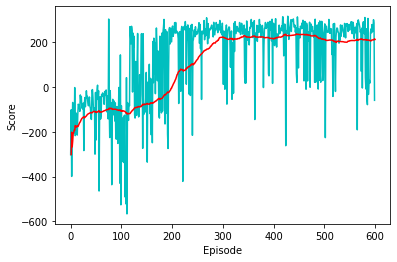

In [ ]:
# Creamos el entorno y el agente
environment, number_of_observations, number_of_actions = create_environment()
environment = gym.wrappers.Monitor(environment, res_path_vid, video_callable=lambda episode_id: episode_id % GRABAR_CADA_X == 0, force=True)
agent = DQN(number_of_observations, number_of_actions)

episode = 0
updt_w = 0
exploration_rates = []
transitions = []
goal_episode = []
goal_reached = False
start_time = time.perf_counter()
best_avg_score = -200

while (episode < NUMBER_OF_EPISODES) and not (goal_reached):
  if episode % 50 == 0:
    guardar_resultados()

  episode += 1
  score = 0
  end_episode = False
  state = environment.reset()
  start = time.time()
  state = discretizar_estado(state)

  while not(end_episode):
      # Seleccionamos una acción para el estado dado
      action = agent.select(state)

      # Ejecutamos la acción en el entorno
      state_next, reward, terminal_state, info = environment.step(action)

      # Discretizamos el estados
      state_next = discretizar_estado(state_next)

      score += reward

      # Guardamos en la memoria la transición (s,a,r,s') 
      agent.remember(state, action, reward, state_next, terminal_state)

      # Aprendizaje del modelo utilizando un batch de transiciones
      agent.learn()
      updt_w += 1

      # Actualizamos los pesos de la target network si es necesario
      if updt_w >= UPDATE_W:
        agent.update_target_weights()
        updt_w = 0

      # Detectamos el fin del episodio
      if terminal_state:
        agent.add_score(score)
        avg_score = np.mean(agent.get_resultados()[-100:])

        end_episode = True 
        exploration_rates.append(round(agent.exploration_rate, 2))
        transitions.append(str(agent.memory.current_size))

        # Si la media de los últimos 100 episodios es 200 o más entonces el problema se considera resuelto
        if avg_score >= 200:
            best_avg_score = avg_score
            #goal_reached = True
            goal_episode.append(1)
            guardar_resultados_goal_reached()
        else:
          goal_episode.append(0)
      
        print("Episode {0:>3}: ".format(episode), end = '')
        print(f"last_reward: {f'{reward:+.2f}': >8} | ", end="")
        print(f"score: {f'{score:+.2f}': >8} | ", end="")
        print(f"avg score: {f'{avg_score:+.2f}': >8} | ", end="")
        print(f"time: {f'{ (time.time() - start)/60:+.2f}m': >8} | ", end="")
        print("(exploration rate: %.2f, " % agent.exploration_rate, end = '')
        print("transitions: " + str(agent.memory.current_size) + ")")
        
      else:
          state = state_next

if goal_reached: print("Reached goal sucessfully.")
else: print("Failure to reach the goal.")

print ("Time:", round((time.perf_counter() - start_time)/60), "minutes")

mostrar_resultados()
environment.close()

# 3 Importar modelo ya entrenado

### 3.1 Función para cargar el modelo

In [9]:
def cargar_modelo():
  with open(path_best_score + 'agente', 'rb') as file:
    agent = pickle.load(file)
  
  #Cargamos el modelo
  model = keras.models.load_model(path_best_score + 'model.h5')
  agent.model = model

  return agent

## 3.2 Funciones relativas al entorno y ejecución del modelo

In [10]:
def create_environment():
    # Create simulated environment
    environment = wrap_env(gym.make("LunarLander-v2"))
    environment = gym.make("LunarLander-v2")
    number_of_observations = environment.observation_space.shape[0]
    number_of_actions = environment.action_space.n
    return environment, number_of_observations, number_of_actions


def discretizar_estado(s):
    state = ( min(5, max(-5, np.round((s[0] / 0.1) * 2) / 2)), \
              min(50, max(-10, np.round((s[1] / 0.1) * 2) / 2)), \
              min(10, max(-10, np.round((s[2] / 0.1) * 2) / 2)), \
              min(10, max(-10, np.round((s[3] / 0.1) * 2) / 2)), \
              min(5, max(-5, np.round((s[4] / 0.1) * 2) / 2)), \
              min(5, max(-5, np.round((s[5] / 0.1) * 2) / 2)), \
              int(s[6]), \
              int(s[7])
            )

    return state

def ejecutar_modelo(agent):
  environment, number_of_observations, number_of_actions = create_environment()
  environment = gym.wrappers.Monitor(environment, res_path_vid, video_callable=lambda episode_id: True, force=True)
  goal_reached = False
  end_episode = False
  score = 0
  state = environment.reset()
  state = discretizar_estado(state)
  start = time.time()
  start_time = time.perf_counter()
  while not(end_episode):
      # Select an action for the current state
      action = agent.select(state)

      # Execute the action on the environment
      state_next, reward, terminal_state, info = environment.step(action)

      # Discretizamos el estados
      state_next = discretizar_estado(state_next)

      score += reward
    
      # Detect end of episode
      if terminal_state:
        if score >= 200:
            goal_reached = True

        print(f"last_reward: {f'{reward:+.2f}': >8} | ", end="")
        print(f"score: {f'{score:+.2f}': >8} | ", end="")
        print(f"time: {f'{ (time.time() - start)/60:+.2f}m': >8} | ", end="")
        print("(transitions: " + str(agent.memory.current_size) + ")")
        end_episode = True 
      else:
        state = state_next

  if goal_reached: print("Reached goal sucessfully.")
  else: print("Failure to reach the goal.")

  print ("Time:", round((time.perf_counter() - start_time)/60), "minutes")

  environment.close()

## 3.3 Función Main para importar, ejecutar el modelo y mostrar video de su funcionamiento

In [16]:
res_path_vid = res_path + '/videos_ejecucion/'

agente = cargar_modelo()
ejecutar_modelo(agente)
mostrar_videos()

last_reward:  +100.00 | score:  +316.90 | time:   +0.22m | (transitions: 197935)
Reached goal sucessfully.
Time: 0 minutes
Episodio: 1
